# Feature Importaces for XGBoost of the Baseline
In this section, we aim to gain a better understanding of the models and which features were most important for each language and the emotion detection decision. We also hope to deepen our understanding of the languages themselves.

We calculate and evalaute the feature importances, which indicate how important a feature is for a decision.
Furthermore, we calculate the SHAP values, which provide information about which features are important and in which direction they influence the predictions. We will describe the influce exemplarily and only for the most important features. We do this for each language seperatly and compare it in the end shortly between the langugaes.


In [47]:
# dependencies
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt



In [48]:
# data
df_english = pd.read_csv(r"C:\Users\Julia\Documents\Uni\Speech-Emotion-Recognition\Data\English\features_english.csv") #"..\Data\English\features_english.csv")
df_german = pd.read_csv(r"C:\Users\Julia\Documents\Uni\Speech-Emotion-Recognition\Data\German\features_german.csv") #'..\Data\German\features_german.csv')
df_italian = pd.read_csv(r"C:\Users\Julia\Documents\Uni\Speech-Emotion-Recognition\Data\Italian\features_italian.csv")#'..\Data\Italian\features_italian.csv')
df_urdu = pd.read_csv(r"C:\Users\Julia\Documents\Uni\Speech-Emotion-Recognition\Data\Urdu\features_urdu.csv") #'..\Data\Urdu\features_urdu.csv')

languages = {
    'english': df_english,
    'german': df_german,
    'italian': df_italian,
    'urdu': df_urdu
}


We use our improved pipeline with standard scaling and SMOTE. Group K-Fold cross-validation is applied for all languages. We use as a model XGBoost.


In [49]:

def separate_feats_labs(df):
    X = df.drop(["emotion", "speaker_id", "filename", "valence"], axis=1)  # Features
    y = df["valence"]  # Labels
    groups = df["speaker_id"]  

    if not df.equals(df_english):
        n_splits = 5
        gkf = GroupKFold(n_splits=n_splits)
    else:
        n_splits = 4
        gkf = GroupKFold(n_splits=n_splits)

    return X, y, groups, gkf, n_splits


def evaluate_features(X, y, groups, gkf, n_splits):
    
    # XGBoost-Pipeline mit StandardScaler und SMOTE
    xgb_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier(random_state=42))
    ])

    shap_values_all = []
    expected_values_all = []
    feature_importances = np.zeros(X.shape[1])

    # Cross-Validation
    for train_idx, val_idx in gkf.split(X, y, groups):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        
        xgb_pipeline.fit(X_train, y_train)

        model = xgb_pipeline.named_steps["classifier"]
        
        # get Feature-Importances 
        feature_importances += model.feature_importances_
        
        # calculate SHAP-Werte
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_val)  # SHAP-Werte für Validierungsdaten
        shap_values_all.append(shap_values.values)
        expected_values_all.append(explainer.expected_value)

    # Feature-Importances avergae
    feature_importances /= n_splits

    # combine SHAP-Werte 
    shap_values_combined = np.concatenate(shap_values_all, axis=0)

    return feature_importances, shap_values_combined, expected_values_all[0]




# German

In [50]:
X, y, groups, gkf, n_splits = separate_feats_labs(df_german)
feature_importances, shap_values_combined,_= evaluate_features(X, y, groups, gkf, n_splits)

### Feature Importances

In [51]:
# Feature-Importance DataFrame 
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
# Top 10 Feature-Importances 
top_ten = feature_importance_df.head(10)


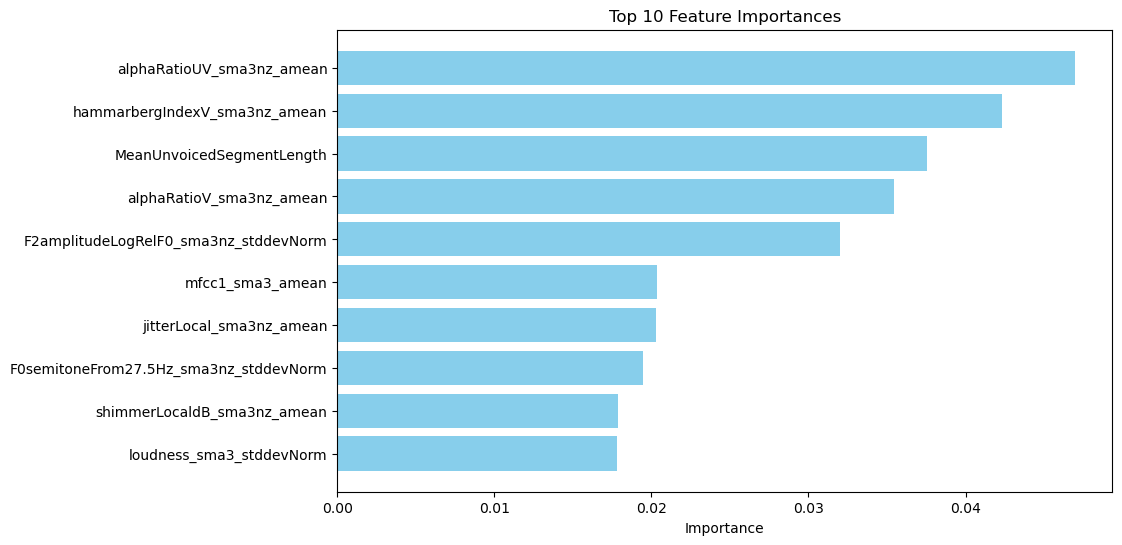

In [52]:
# Plotting the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_ten["Feature"], top_ten["Importance"], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In the plot you can see the top 10 features calcaulted by feature importances. 
The most important feature is alphaRatioUV_sma3nz_amean. It means: Alpha ratio in unvoiced segments (UV) – average smoothed value. Measures the balance of high vs. low frequencies in unvoiced speech.
The values are relatvly small for all features, that could be as we have 88 features.
Feature Importances doesn't tell how features influence predictions (positively or negatively), thats why we look at the Shap values.



### SHAP Values

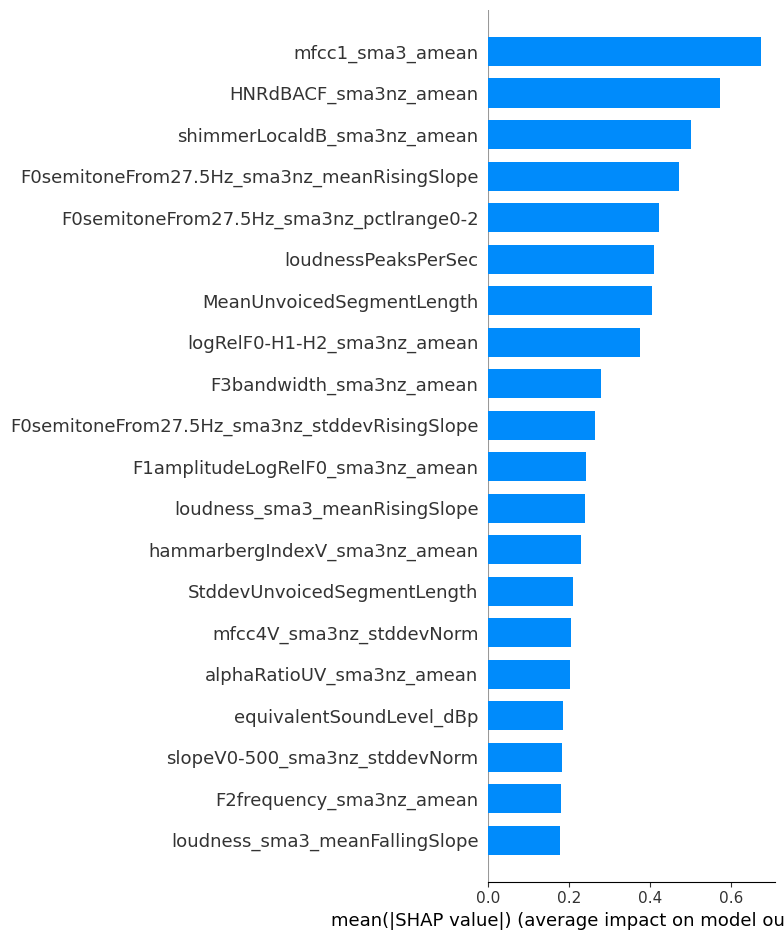

In [53]:

shap.summary_plot(shap_values_combined, features=X, plot_type="bar", show=False)


This is a bar chart ranking features by their average absolute SHAP value. It provides a straightforward way to see which features have the highest impact in a positive or negative direction.
At the top is mfcc1_sma3_mean, which indicates that this MFCC feature is the most important for the model.
Other important features: HNRdBACF_sma3nz_mean, shimmerLocaldB_sma3nz_mean, F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope.
You can see this also in the plot below more easliy.
mfcc1_sma3_mean is the average value of the first MFCC (Mel-Frequency Cepstral Coefficient), smoothed over time. It tells us something about the overall sound energy or tone in the voice.


When we compare this with the traditional feature importance plot, the results are different. That’s because the feature importance plot shows how often a feature is used by the model, while SHAP shows how much a feature actually changes the prediction.
Only mfcc3_sma3_amean shows up in both plots. The fact that mfcc3_sma3_amean appears in both means it’s a very important feature. It’s used often and it has a big impact.
We just wanted to point out this difference. Going forward, we’ll mainly focus on SHAP values and also only on the Beewarm plot, because this tell us more directly how each feature influences the predictions.


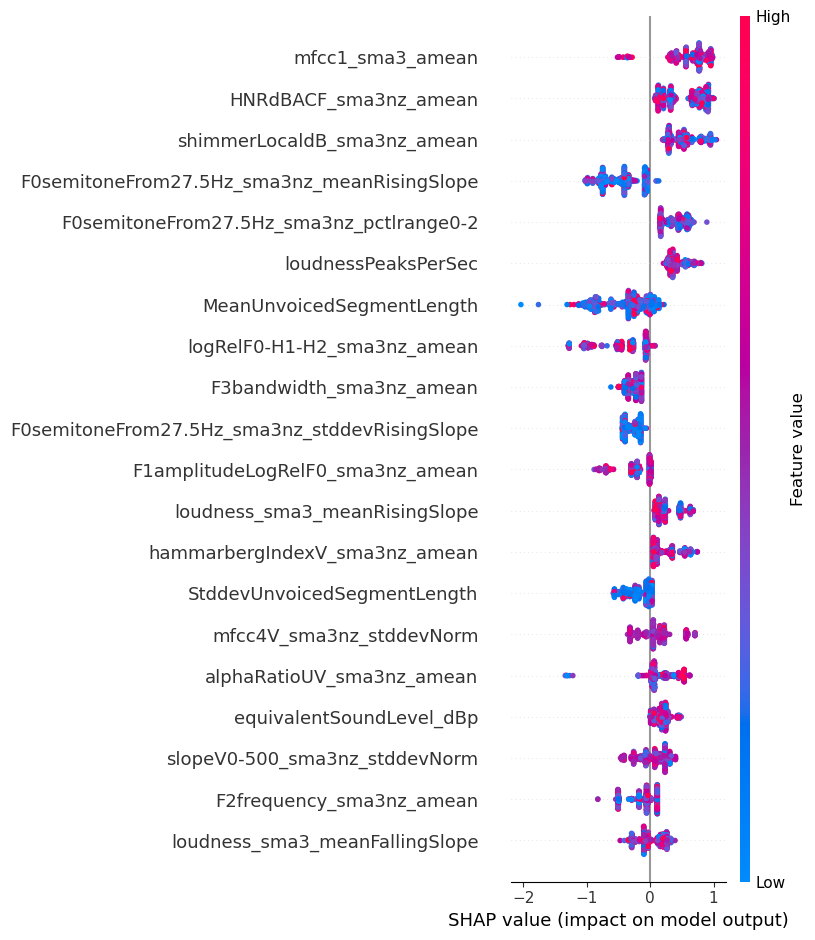

In [54]:
# SHAP Summary Plot
shap.summary_plot(shap_values_combined, features=X)

Here you can see the Beeswarm plot. It is more complex and information rich.
The x-axis shows the SHAP value, which is the contribution of a feature to the model prediction. A positive SHAP value means the feature is pushing the prediction up, a negative value pushes it down.
The Y-axis lists the features sorted by their average impact on the model (decreasing from top to bottom).
Each point is a single data point from the data set. Looking at the distribution of the SHAP values shows how a variable can affect the model's prediction.

The colour (from blue to red) represents the actual value of the feature (low to high). Examining the colour distribution horizontally along the x-axis for each variable provides insight into the general relationship between a variable's raw value and its SHAP value. 

We can see that the feature mfcc3_sma3_amean has a high impact on the model's output, especially when the feature values are high. However, there are also instances with low feature values.

For the feature F0semitoeFrom27.5Hz_sma3nz_amean, most of the data points have low feature values, and the model's impact is negative.
F0semitoeFrom27.5Hz_sma3nz_amean is a feature derived from the fundamental frequency (F0), with a focus on frequencies above 27.5 Hz. The feature is smoothed using a short-term moving average over 3 data points, considering only non-zero values, and then the mean is taken for the processed data.

# Italian

### Feature Importance

In [55]:
X, y, groups, gkf, n_splits = separate_feats_labs(df_italian)
feature_importances, shap_values_combined,_= evaluate_features(X, y, groups, gkf, n_splits)
# Feature-Importance DataFrame 
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
# Top 10 Feature-Importances 
feature_importance_df.head(10)


,Feature,Importance
51,F2amplitudeLogRelF0_sma3nz_stddevNorm,0.044274
57,F3amplitudeLogRelF0_sma3nz_stddevNorm,0.036500
14,loudness_sma3_percentile80.0,0.033061
24,mfcc2_sma3_amean,0.029482
65,slopeV500-1500_sma3nz_stddevNorm,0.029015
20,spectralFlux_sma3_amean,0.025077
16,loudness_sma3_meanRisingSlope,0.022226
87,equivalentSoundLevel_dBp,0.021041
50,F2amplitudeLogRelF0_sma3nz_amean,0.018852
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.018142


As mentioned earlier, we only take a closer look at the SHAP values.

### SHAP Values

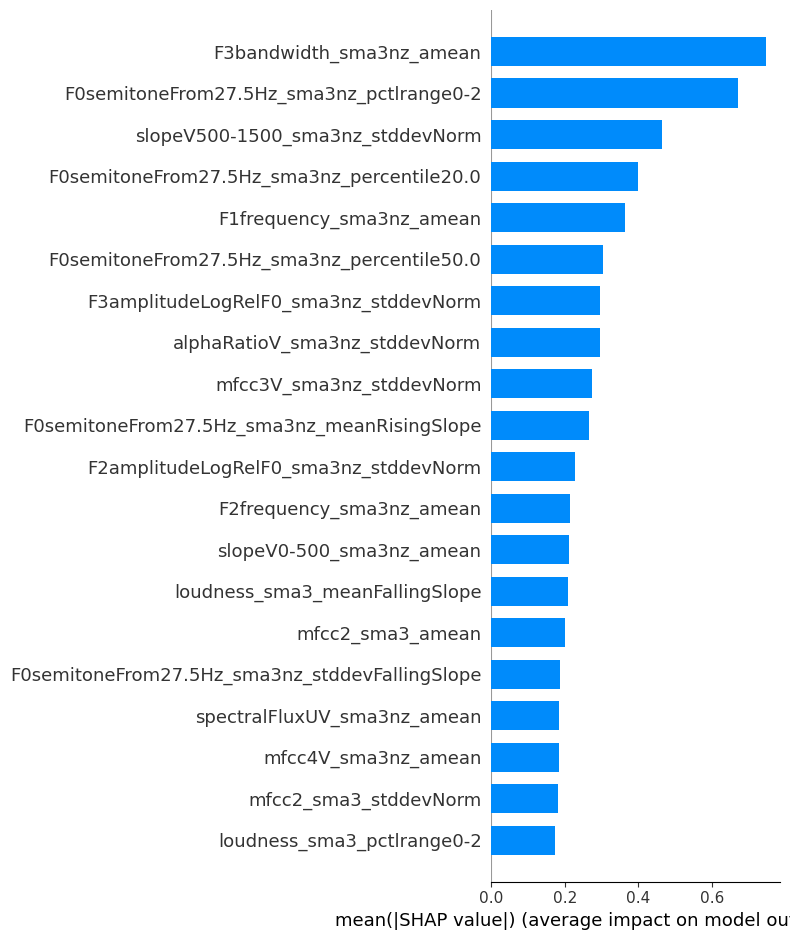

In [56]:
shap.summary_plot(shap_values_combined, features = X, plot_type="bar")

Here we see that F3bandwidth_sma3nz_amean and F0semitoneFrom27.5Hz_sma3nz_pctlrang0-2 are the most important features.
F3bandwidth_sma3nz_amean is the average smoothed bandwidth of the third formant. It tells us something about the clarity or sharpness of speech sounds, especially those that use the back of the tongue (like r or l).
F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2 shows how much the pitch varies in the very lowest 2% of the pitch range — useful for detecting things like monotone speech or low-frequency irregularities.


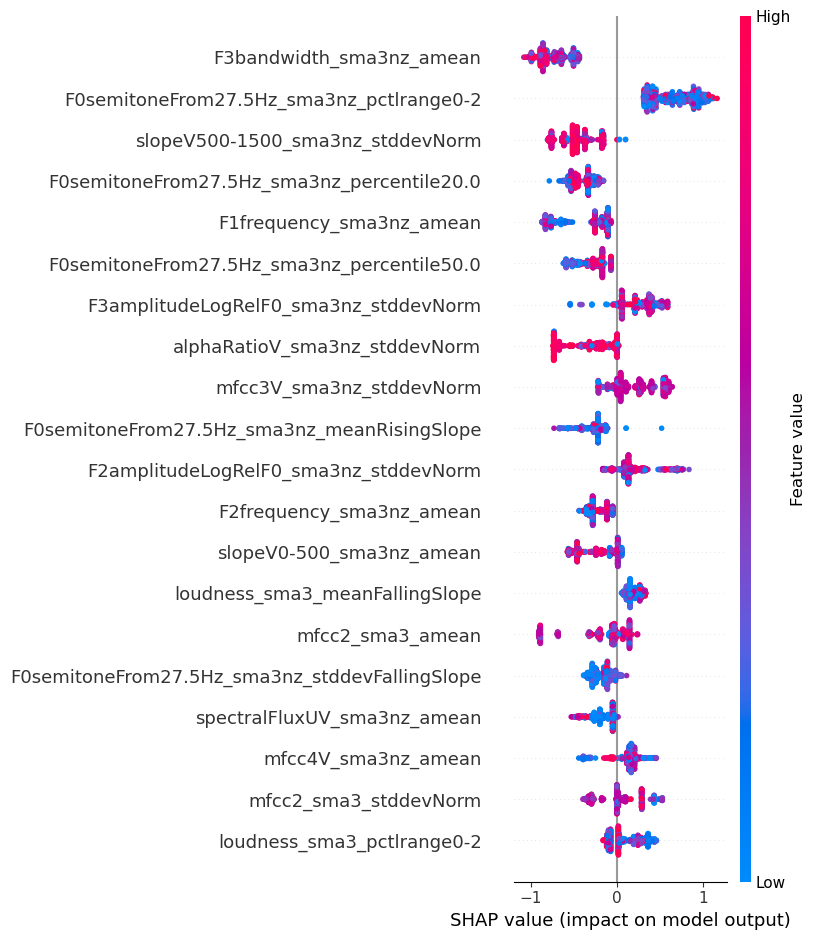

In [57]:
# SHAP Summary Plot
shap.summary_plot(shap_values_combined, features=X)


We can see that higher values of F3bandwidth_sma3nz_amean have a more negative impact on the model. On the other hand, F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2 results in a positive model output when the feature values are lower.

# English

### Feature Importances

In [58]:
X, y, groups, gkf, n_splits = separate_feats_labs(df_english)
feature_importances, shap_values_combined,_= evaluate_features(X, y, groups, gkf, n_splits)
# Feature-Importance DataFrame 
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
# Top 10 Feature-Importances 
feature_importance_df.head(10)


,Feature,Importance
0,F0semitoneFrom27.5Hz_sma3nz_amean,0.035939
87,equivalentSoundLevel_dBp,0.035909
10,loudness_sma3_amean,0.032129
5,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,0.032066
66,spectralFluxV_sma3nz_amean,0.031850
4,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.030775
45,F1amplitudeLogRelF0_sma3nz_stddevNorm,0.026145
76,alphaRatioUV_sma3nz_amean,0.021958
58,alphaRatioV_sma3nz_amean,0.021911
20,spectralFlux_sma3_amean,0.020957


### SHAP Values

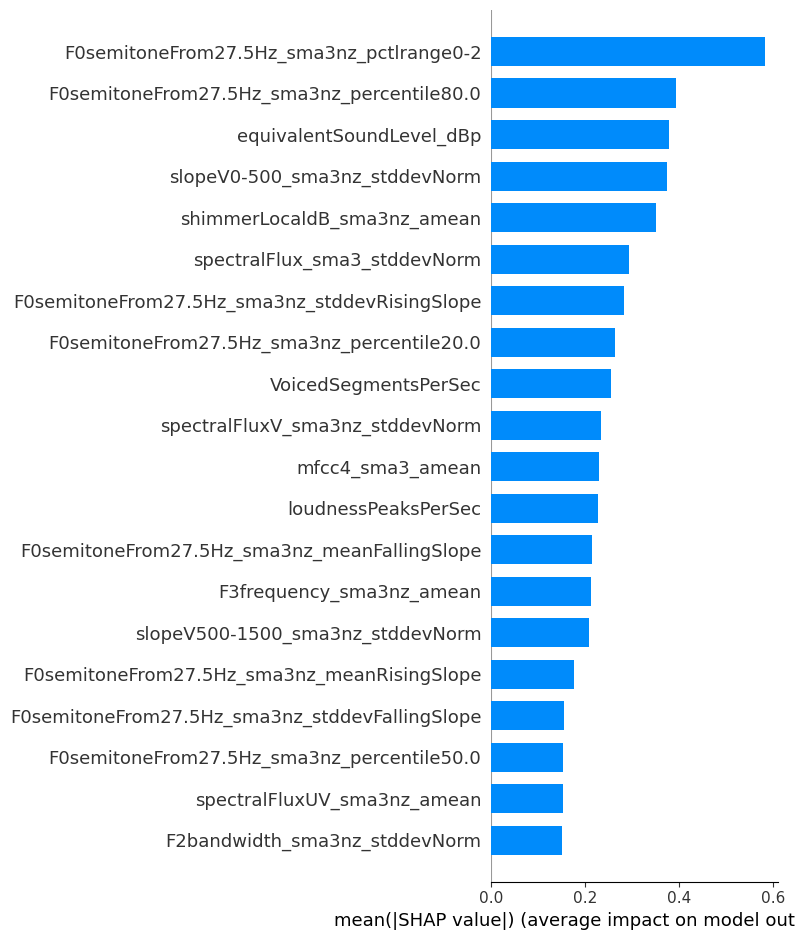

In [59]:
shap.summary_plot(shap_values_combined, features = X, plot_type="bar")

In English, we also have F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2 as the most important feature. The other features are considerably less important in the decisions made by the XGBoost model.

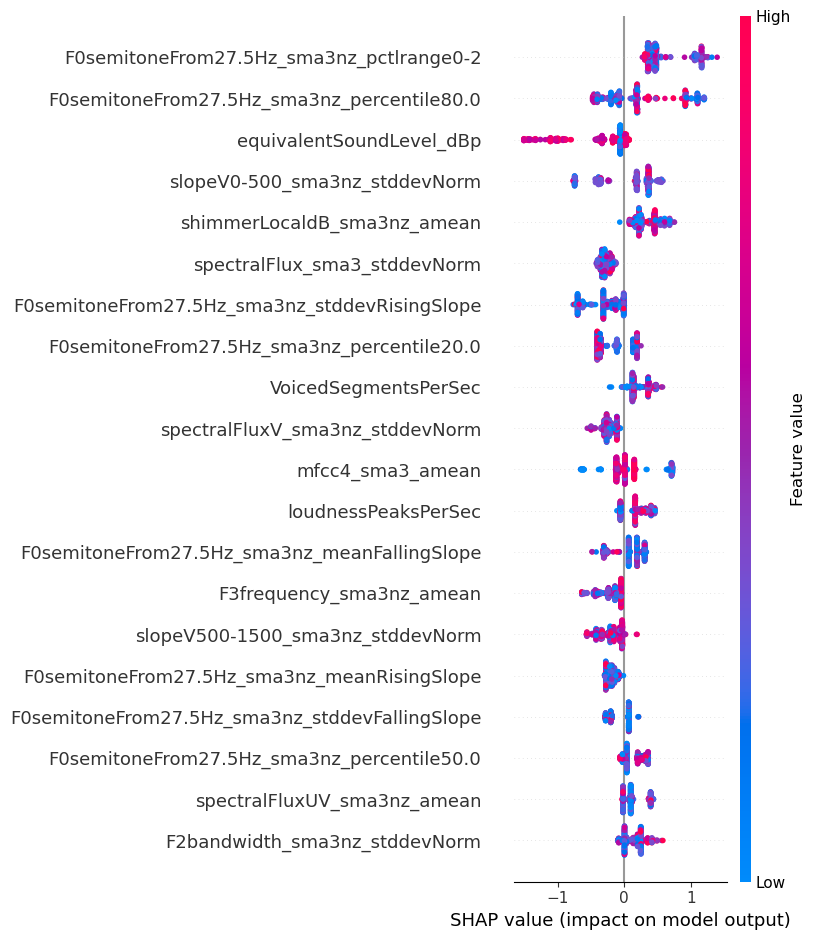

In [60]:
# SHAP Summary Plot
shap.summary_plot(shap_values_combined, features=X)


F0semitoneFrom27.5Hz_sma3nz_pctlrang0-2 has a high positive impact.
EquivalantSoundLevel_dBp has for high values a negative impact on the model. Lower values do not have an impact.

# Urdu

### Feature Importances

In [61]:
X, y, groups, gkf, n_splits = separate_feats_labs(df_urdu)
feature_importances, shap_values_combined,_= evaluate_features(X, y, groups, gkf, n_splits)
# Feature-Importance DataFrame 
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
# Top 10 Feature-Importances 
feature_importance_df.head(10)


,Feature,Importance
26,mfcc3_sma3_amean,0.105921
78,slopeUV0-500_sma3nz_amean,0.043916
22,mfcc1_sma3_amean,0.042886
62,slopeV0-500_sma3nz_amean,0.038964
38,logRelF0-H1-A3_sma3nz_amean,0.031889
55,F3bandwidth_sma3nz_stddevNorm,0.030843
19,loudness_sma3_stddevFallingSlope,0.028836
20,spectralFlux_sma3_amean,0.028734
3,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.027890
14,loudness_sma3_percentile80.0,0.023539


### SHAP Values

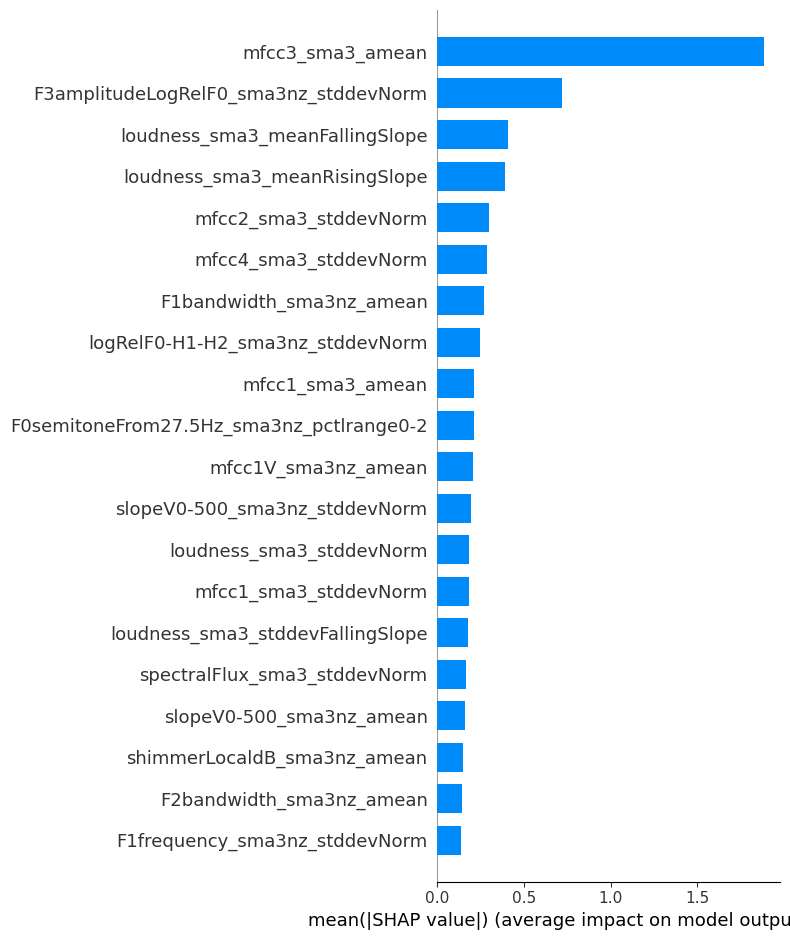

In [62]:
shap.summary_plot(shap_values_combined, features = X, plot_type="bar")

mfcc3_sma3_mean is the most important feature in the urdu language. All the other are significant less important.

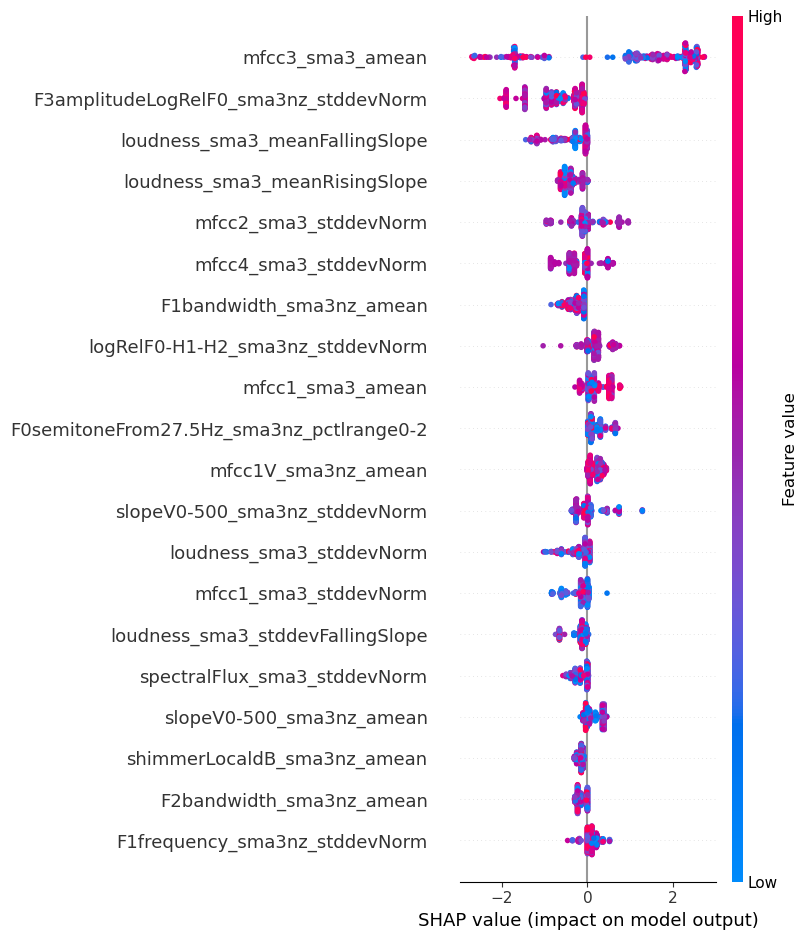

In [63]:
# SHAP Summary Plot
shap.summary_plot(shap_values_combined, features=X)


mfcc3_sma3_amean is clearly the most important feature. It has mixed impacts with mixed feature values.

### Conclusion
German and Urdu share at least one of the most important features. Similarly, Italian and English also share at least one key feature. This outcome does not align with our initial expectations, as German and English are both West Germanic languages, while Italian belongs to the Romance language family and Urdu to the Indo-Aryan family. German and English are structurally similar, whereas Italian tends to have a more melodic intonation and a faster speech rate. Urdu differs in its tone accent system and syllabic rhythm.

Overall, we were able to identify the most important features; however, the SHAP plots often appeared highly "mixed." This is commonly due to the fact that a feature's impact is not linear or consistent across the dataset. In some cases, interactions with other features cause the same feature value to behave differently in different samples. This reflects the complexity of the model—or, more broadly, the complexity of the emotion detection task itself. Therefore, it remains challenging to determine the linguistic differences in emotional expression solely based on our XGBoost model, due to the complexity and variability observed in the SHAP analyses. 

In the future, more advanced models that can capture complex patterns should be explored in the field of emotion detection. Architectures such as Transformers, Autoencoders, or LSTMs may offer improved performance and deeper insights. These models were not used in our project, as they were not part of the lecture curriculum.
